# Tesla Stock Price Prediction, Feature Pruning
### Second Semester Capstone

In this notebook I'm experimenting with using fewer features, but also adding more lookback (i.e. instead of using features from point t-1, also include t-2, t-3, etc). So far I've received about 7.1% error using just the Google Trends data and a lookback of 5 (going back to point t-5), and attempts with higher lookback, such as 10, increase the amount of error.

In [1]:
import pandas as pd
import numpy as np
#tf.compat.v1.disable_v2_behavior()
from math import sqrt, floor
from matplotlib import pyplot
from statistics import mean

# LSTM Application

## Preparing Data

In [2]:
# Loading Preprocessed Data File
df = pd.read_csv("../Data/preprocessed.csv",usecols=['Date','Close','Tesla Trend','Musk Tweet Count'], parse_dates=['Date'],index_col=0)
df.dropna(inplace=True)

print(df.shape)
df.head()

(2699, 3)


,Close,Musk Tweet Count,Tesla Trend
Date,,,
2010-07-01,4.392,0.0,7.00
2010-07-02,3.840,0.0,6.09
2010-07-06,3.222,0.0,2.10
2010-07-07,3.160,0.0,3.78
2010-07-08,3.492,0.0,5.60


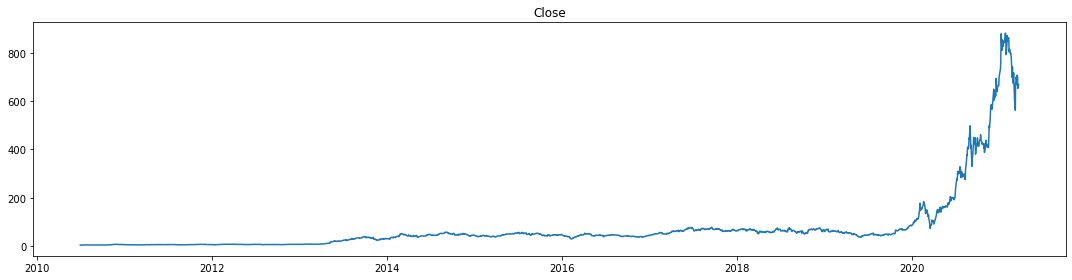

In [3]:
dates = df.index.to_numpy()
pyplot.figure(figsize=(15,4))

pyplot.plot(dates, df["Close"], label="Close")
pyplot.title("Close")

pyplot.tight_layout()
pyplot.show()

### Function For Converting Time Series Data For Supervised Learning

In [4]:
# convert series to supervised learning
# developed in this blog post https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
def series_to_supervised(data, col_names, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df_temp = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df_temp.shift(i))
        names += [('%s(t-%d)' % (col_names[j], i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ..., t+n)
    for i in range(0, n_out):
        cols.append(df_temp.shift(-i))
        if i == 0:
            names += [('%s(t)' % (col_names[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%d)' % (col_names[j], i)) for j in range(n_vars)]
	# put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
	# drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

### Converting Data for Supervised Learning

In [59]:
from sklearn.preprocessing import MinMaxScaler

values = df.values
# integer encoding of labels (not using yet here since we don't have non-numerical data)
#encoder = LabelEncoder()
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, df.columns, 9, 1)

# Drop Columns of Variables We Aren't Predicting
# We want only the variable we're predicting for time t
reframed.drop(reframed.loc[:, 'Close(t-6)':'Tesla Trend(t-1)'], axis=1, inplace=True)
reframed.drop(reframed.loc[:, 'Musk Tweet Count(t)':'Tesla Trend(t)'], axis=1, inplace=True)

print(reframed.shape)
reframed.head()

(2690, 10)


,Close(t-9),Musk Tweet Count(t-9),Tesla Trend(t-9),Close(t-8),Musk Tweet Count(t-8),Tesla Trend(t-8),Close(t-7),Musk Tweet Count(t-7),Tesla Trend(t-7),Close(t)
9,0.001400,0.0,0.060606,0.000773,0.0,0.051414,0.000070,0.0,0.011111,0.000930
10,0.000773,0.0,0.051414,0.000070,0.0,0.011111,0.000000,0.0,0.028081,0.001100
11,0.000070,0.0,0.011111,0.000000,0.0,0.028081,0.000377,0.0,0.046465,0.001389
12,0.000000,0.0,0.028081,0.000377,0.0,0.046465,0.000364,0.0,0.037273,0.001023
13,0.000377,0.0,0.046465,0.000364,0.0,0.037273,0.000284,0.0,0.026667,0.001005


In [60]:
values = reframed.values
# split into train, test, and prediction sets
n_predict = 365 # We are predicting 365 days
n_train = floor((len(values)-n_predict) * 0.80) # 80% of the data is currently used for train (can be adjusted)
train = values[:n_train, :]
test = values[n_train:len(values)-n_predict, :] # What's left is used for test
predict = values[len(values)-n_predict:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
predict_X, predict_y = predict[:, :-1], predict[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
predict_X = predict_X.reshape((predict_X.shape[0], 1, predict_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape, predict_X.shape, predict_y.shape)

(1860, 1, 9) (1860,) (465, 1, 9) (465,) (365, 1, 9) (365,)


## Running Model

In [61]:
# Import keras libraries
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.constraints import NonNeg
#from tensorflow.keras.callbacks import Callback

# Unused
"""
class stopAtLossValue(Callback):
        def on_batch_end(self, batch, logs={}):
            THR = 0.009 #Assign THR with the value at which you want to stop training.
            if logs.get('loss') <= THR:
                 self.model.stop_training = True
"""

"\nclass stopAtLossValue(Callback):\n        def on_batch_end(self, batch, logs={}):\n            THR = 0.009 #Assign THR with the value at which you want to stop training.\n            if logs.get('loss') <= THR:\n                 self.model.stop_training = True\n"

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50)                12000     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 12,051
Trainable params: 12,051
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
4/4 - 1s - loss: 0.0275 - accuracy: 0.0000e+00 - val_loss: 0.0451 - val_accuracy: 0.0000e+00
Epoch 2/150
4/4 - 0s - loss: 0.0230 - accuracy: 0.0000e+00 - val_loss: 0.0341 - val_accuracy: 0.0000e+00
Epoch 3/150
4/4 - 0s - loss: 0.0205 - accuracy: 0.0000e+00 - val_loss: 0.0244 - val_accuracy: 0.0000e+00
Epoch 4/150
4/4 - 0s - loss: 0.0183 - accuracy: 0.0000e+00 - val_loss: 0.0175 - val_accuracy: 0.0000e+00
Epoch 5/150
4/4 - 0s - loss: 0.0165 - accuracy: 0.0000e+00 - val_loss: 0.0142 - val_accuracy

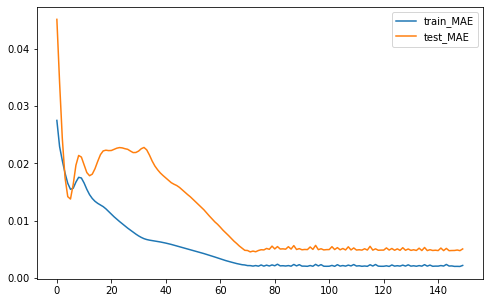

In [62]:
# Design Network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=False))
model.add(Dense(1, activation="linear", kernel_constraint=NonNeg()))

model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
model.summary()

# fit network
# epochs = how long you're running it
# batch_size = number of training samples to use in an epoch
history = model.fit(train_X, train_y, epochs=150, batch_size=600, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.figure(figsize=(8,5))
pyplot.plot(history.history['loss'], label='train_MAE')
pyplot.plot(history.history['val_loss'], label='test_MAE')
pyplot.legend()
pyplot.show()

### Prediction

In [63]:
# make a prediction
yhat = model.predict(predict_X)
predict_X_2D = predict_X.reshape((predict_X.shape[0], predict_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, predict_X_2D[:, 1:]), axis=1)
inv_yhat = scaler.fit(inv_yhat).inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
predict_y = predict_y.reshape((len(predict_y), 1))
inv_y = np.concatenate((predict_y, predict_X_2D[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

### Metrics

In [64]:
from sklearn.metrics import mean_squared_error

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
normalized_rmse = rmse/(mean(inv_y))
print('Normalized RMSE: %.3f' % normalized_rmse)

Test RMSE: 0.052
Normalized RMSE: 0.134


In [65]:
# Finding the predicted quarterly maximums
dates = dates[len(dates)-n_predict:]

#maxes = [dates[np.argmax(yhat[0:89], axis=0)]]
#maxes_actual = [dates[np.argmax(predict_y[0:89], axis=0)]]
maxes = [
    dates[np.argmax(yhat[0:89], axis=0)], 
    dates[np.argmax(yhat[90:179], axis=0)+90], 
    dates[np.argmax(yhat[180:269], axis=0)+180], 
    dates[np.argmax(yhat[270:364], axis=0)+270]
]
maxes_actual = [
    dates[np.argmax(predict_y[0:89], axis=0)], 
    dates[np.argmax(predict_y[90:179], axis=0)+90], 
    dates[np.argmax(predict_y[180:269], axis=0)+180], 
    dates[np.argmax(predict_y[270:364], axis=0)+270]
]

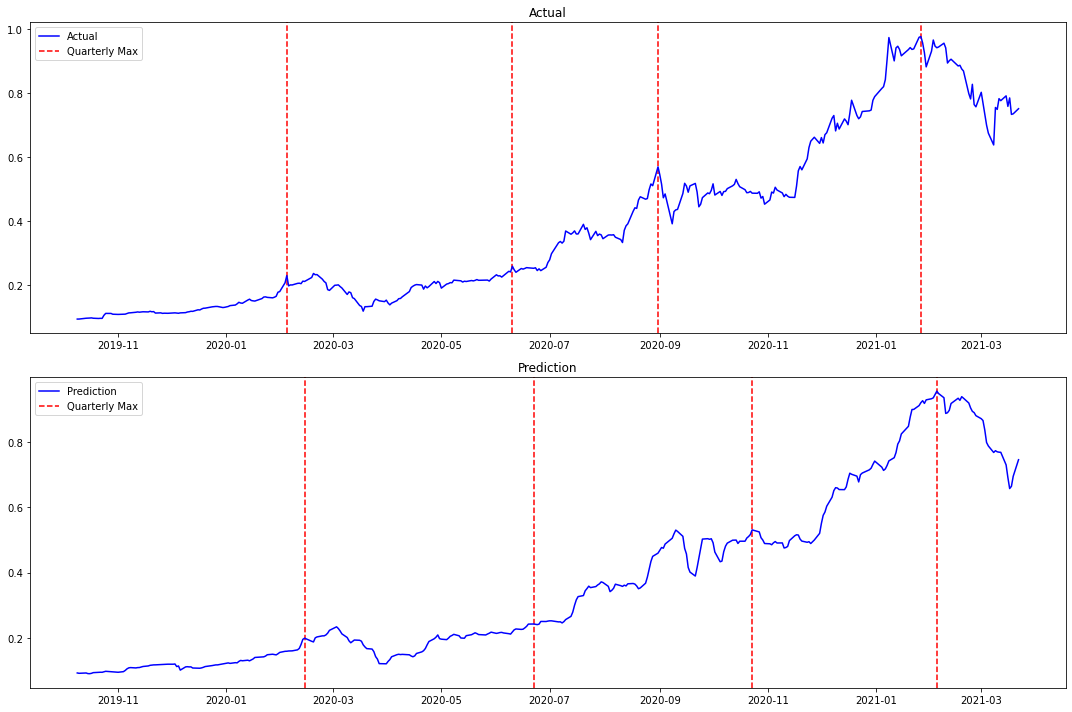

In [66]:
# Plot of Prediction vs Actual
pyplot.figure(figsize=(15,10))

pyplot.subplot(2, 1, 1)
pyplot.plot(dates, inv_y, color='b', label="Actual", zorder=2)
# Adding dashed lines for the quarterly maximums
pyplot.axvline(x=maxes_actual[0], color='r', linestyle='--', label='Quarterly Max', zorder=1)
for xc in maxes_actual[1:]:
    pyplot.axvline(x=xc, color='r', linestyle='--', zorder=1)
pyplot.legend(loc='upper left')
pyplot.title("Actual")

pyplot.subplot(2, 1, 2)
pyplot.plot(dates, inv_yhat, color='b', label="Prediction", zorder=2)
# Adding dashed lines for the quarterly maximums
pyplot.axvline(x=maxes[0], color='r', linestyle='--', label='Quarterly Max', zorder=1)
for xc in maxes[1:]:
    pyplot.axvline(x=xc, color='r', linestyle='--', zorder=1)
pyplot.legend(loc='upper left')
pyplot.title("Prediction")

pyplot.tight_layout()
pyplot.show()

In [67]:
# Printing the dates of each quarterly maximum
for i in range(len(maxes)):
    print("Q%i Max: %s" %(i+1, maxes[i][0]))
    print("Q%i Actual Max: %s" %(i+1, maxes_actual[i][0]))
    print("Diff: %s" %abs((maxes_actual[i][0]-maxes[i][0]).astype('timedelta64[D]')))

Q1 Max: 2020-02-14T00:00:00.000000000
Q1 Actual Max: 2020-02-04T00:00:00.000000000
Diff: 10 days
Q2 Max: 2020-06-22T00:00:00.000000000
Q2 Actual Max: 2020-06-10T00:00:00.000000000
Diff: 12 days
Q3 Max: 2020-10-23T00:00:00.000000000
Q3 Actual Max: 2020-08-31T00:00:00.000000000
Diff: 53 days
Q4 Max: 2021-02-04T00:00:00.000000000
Q4 Actual Max: 2021-01-26T00:00:00.000000000
Diff: 9 days


In [69]:
import shap

# Create explainer for SHAP feature analysis
explainer = shap.GradientExplainer(model, train_X)
shap_values = explainer.shap_values(predict_X)
shap.initjs()

# Data has to be converted to 2D
shap_values_2D = shap_values[0].reshape(-1,9)

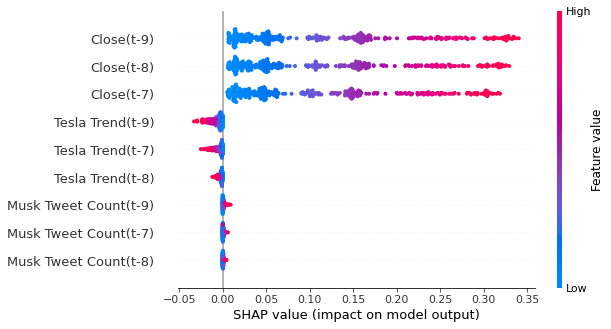

In [70]:
# Plot of Feature Importance
shap.summary_plot(shap_values_2D, features=predict_X_2D, feature_names=reframed.columns)